# Imports

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from pmesh.pm import ParticleMesh as PMnew
from nbodykit.lab import BigFileCatalog, BigFileMesh, FFTPower, MultipleSpeciesCatalog
from matplotlib.colors import LogNorm
from scipy.integrate import simps
from time import time


# import os, sys
# sys.path.append('../cosmo4d/')
# from lab import *

# import h5py, bigfile, json
# import importlib
# import os, sys

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append("/global/homes/c/chmodi/Programs/cosmo4dv2/")
sys.path.append('/global/homes/c/chmodi/Programs/cosmo4dv2/cosmo4d/')
sys.path.append('/global/homes/c/chmodi/Programs/cosmo4dv2/train_nets')
import features as ft
import datalib as lib
import datatools as dtools
import nettools as ntools
import sigtools as stools
import diagnostic as dg
import mymass_function as mass_function
%matplotlib inline

pfile = "/global/homes/c/chmodi/Data/ics_matterpow_0.dat"
klin, plin = np.loadtxt(pfile, unpack=True)
mf = mass_function.Mass_Func(pfile, 0.3175)
# cosmo = Planck15.clone(Omega_cdm = 0.2685, h = 0.6711, Omega_b = 0.049)

# from cosmo4d import maplhd as mapp
# from cosmo4d import nbody
# from cosmo4d import report as dgrep
# from cosmo4d.iotools import load_map as loadmap

# # sys.path.append('/global/homes/c/chmodi/Programs/Py_codes/modules/')
# # import mytools as tools
# # import mycosmology

# #import mysigmoid as sigmoid



In [3]:
seed, nsteps = 100, 5
bs, nc = 400., 128
pm = PMnew(BoxSize=bs, Nmesh=[nc, nc, nc], dtype = "f8")
numd = 5e-4
numd1 = 1e-3
num = int(numd*pm.BoxSize.prod())
M0 = 1e11
Rsm = 3
zz = 0 
# numd = 5e-4
numd = 1e-3


In [4]:
# proj = '/project/projectdirs/cosmosim/lbl/chmodi/cosmo4d/'
# scratch = '/global/cscratch1/sd/chmodi/cosmo4d/'
# train = scratch + 'train/'
# dpath = proj + 'data/L%04d_N%04d_S%04d_%02dstep/lhd/n%02d/'
# ppath = proj + 'train/L%04d_N%04d_%02dstep-n%02d/cfcl273noa/'%(bs, nc, nsteps, numd*1e4)
# outpath = scratch + 'output/L%04d_N%04d_%02dstep-fof/lhd_S%04d/n%02d/'


# outpath2 = proj + 'output/L%04d_N%04d_S%04d_%02dstep-fof/lhd/n%02d/'


# Diagnostics

In [5]:
# del fitp, bestp, datap, report, reportf
ftup, fitp, bestp, datap = {}, {}, {}, {}
report, reportf = {}, {}

In [8]:

ftup['400'] = (400, 128, nsteps, seed, numd*1e4)

def loadfile(key, folder, ipath, subf = 'best-fit', mesh=False, keycheck=True, keyskip = True, verbose=False):
    if key in report.keys() and keycheck:
        if verbose: print('Key clash for %s'%key)
        if keyskip: return None
    bestm = mapp.Observable.load(ipath + '%s/%s'%(folder, subf))
    datam = mapp.Observable.load(ipath + 'datap')
    fitm = mapp.Observable.load(ipath + 'fitp').mapp
    report[key] = dgrep.evaluate(bestm, datam)[:-2]
    reportf[key] = dgrep.evaluate1(fitm, datam.mapp)
    if mesh:
        bestp[key], datap[key], fitp[key] = bestm, datam, fitm

In [9]:
def skeys(pattern, dd=report):
    toret = []
    for key in dd.keys():
        if pattern in key: toret.append(key)
    return toret

def skeys2(pattern, dd=report):
    toret = []
    for key in dd.keys():
        if re.search(pattern , key) is not None: toret.append(key)
    return toret

def rd(rp, report=report):
    tr = {}
    tr['k'] = rp[0]['k']
    tr['modes'] = rp[0]['modes']
    keys = ['xm', 'xs', 'xd', 'pm1', 'pm2', 'ps1', 'ps2', 'pd1', 'pd2']
    for i, key in enumerate(keys):
        tr[key] = rp[i]['power']
    for key in tr.keys(): tr[key] = tr[key][1:]
    return tr

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

In [10]:
def diagnostic1(folder, reconfolder):
    trues = BigFileMesh(folder + 'datap', 's').paint()+1
    truep = BigFileMesh(folder + 'datap', 'mapp').paint()
    recons = BigFileMesh(folder +  reconfolder , 's').paint()+1
    reconp = BigFileMesh(folder + reconfolder , 'mapp').paint()
    trues /= trues.cmean()
    truep /= truep.cmean()
    recons /= recons.cmean()
    reconp /= reconp.cmean()
    
    ps, psr, psx = FFTPower(trues, mode='1d').power, FFTPower(recons, mode='1d').power, FFTPower(trues, second=recons, mode='1d').power
    pp, ppr, ppx = FFTPower(truep, mode='1d').power, FFTPower(reconp, mode='1d').power, FFTPower(truep, second=reconp, mode='1d').power

    fig, ax = plt.subplots(2, 3, figsize = (12, 8))
    
    ax[0, 0].imshow(trues[...].sum(axis=0), aspect='auto')
    ax[0, 1].imshow(truep[...].sum(axis=0), aspect='auto')
    ax[1, 0].imshow(recons[...].sum(axis=0), aspect='auto')
    ax[1, 1].imshow(reconp[...].sum(axis=0), aspect='auto')
    ax[0, 2].plot(ps['k'], psr['power'] * ps['power']**-1, )
    ax[0, 2].plot(ps['k'], ppr['power'] * pp['power']**-1, '--')
    ax[1, 2].plot(ps['k'], psx['power']*(psr['power'] * ps['power'])**-0.5, )
    ax[1, 2].plot(ps['k'], ppx['power']*(ppr['power'] * pp['power'])**-0.5,'--' )
    for axis in ax[:, 2]:
        axis.set_xscale('log')
        axis.grid(which='both')
        axis.set_ylim(-0.01, 1.2)
    plt.show()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in reciprocal
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in reciprocal
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power


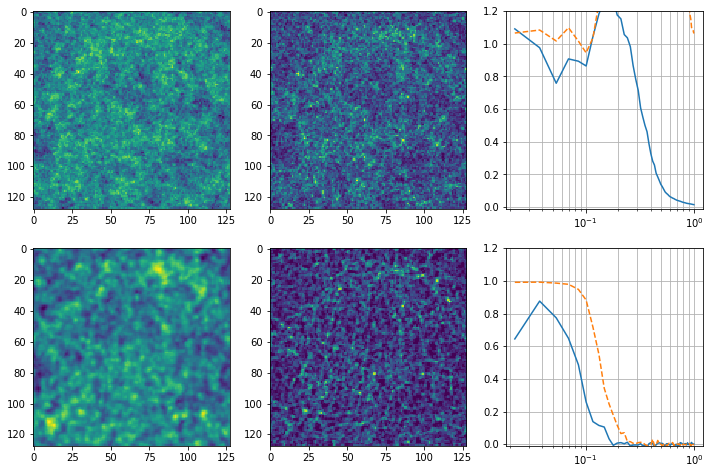

In [11]:
outpath10 = '/global/cscratch1/sd/chmodi/cosmo4d/output/version2/L0400_N0128_05step-fof/lhd_S0100/n10/'
outpath05 = '/global/cscratch1/sd/chmodi/cosmo4d/output/version2/L0400_N0128_05step-fof/lhd_S0100/n05/'
outpathpos = '/global/cscratch1/sd/chmodi/cosmo4d/output/version2/L0400_N0128_05step-fof/lhd_S0100/n10/position/initp90/overdensity/'


# folder = outpath10 + 'opt_s999_iM12-sm3v25off-sg30/'
# reconfolder = 'M0_120/128-01-1.00/0020/fit_p'
folder = outpathpos + 'opt_s999_iM12-sm3v100off/'
reconfolder = 'M0_120/128-01-2.00//0020/fit_p'


diagnostic1(folder, reconfolder)

Compare reconstruction in case of different scatters


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '$r_c$')

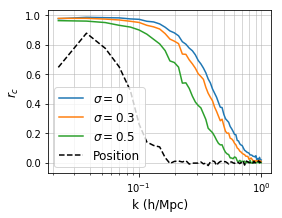

In [29]:
print('Compare reconstruction in case of different scatters')

def tmpfunc(folder, reconfolder):
    trues = BigFileMesh(folder + 'datap', 's').paint()+1
    truep = BigFileMesh(folder + 'datap', 'mapp').paint()
    recons = BigFileMesh(folder +  reconfolder , 's').paint()+1
    reconp = BigFileMesh(folder + reconfolder , 'mapp').paint()
    trues /= trues.cmean()
    truep /= truep.cmean()
    recons /= recons.cmean()
    reconp /= reconp.cmean()
    
    ps = FFTPower(trues, mode='1d').power
    k, ps = ps['k'], ps['power']
    psr, psx = FFTPower(recons, mode='1d').power['power'], FFTPower(trues, second=recons, mode='1d').power['power']
    pp, ppr, ppx = FFTPower(truep, mode='1d').power['power'], FFTPower(reconp, mode='1d').power['power'], FFTPower(truep, second=reconp, mode='1d').power['power']

    pks = [k, [ps, psr, psx], [pp, ppr, ppx]]
    return pks

fig, ax = plt.subplots(1,1, figsize = (4, 3), sharex=True, sharey=True)
ax = [ax]
folder = outpath10 + 'opt_s999_iM12-sm3v25off/'
reconfolder = 'M0_120/128-03-0.00/best-fit'
k, pks, pkp = tmpfunc(folder, reconfolder)
ps, pr, psrx = pks
plt.plot(k, psrx/(ps*pr)**0.5, 'C0-', label='$\sigma=0$')

folder = outpath10 + 'opt_s999_iM12-sm3v25off-sg30/'
reconfolder = 'M0_120/128-03-0.00/best-fit'
k, pks, pkp = tmpfunc(folder, reconfolder)
ps, pr, psrx = pks
plt.plot(k, psrx/(ps*pr)**0.5, 'C1-', label='$\sigma=0.3$')


folder = outpath10 + 'opt_s999_iM12-sm3v25off-sg50/'
reconfolder = 'M0_120/128-03-0.00/best-fit'
k, pks, pkp = tmpfunc(folder, reconfolder)
ps, pr, psrx = pks
plt.plot(k, psrx/(ps*pr)**0.5, 'C2-', label='$\sigma=0.5$')

folder = outpathpos + 'opt_s999_iM12-sm3v100off/'
reconfolder = 'M0_120/128-01-2.00//0020/fit_p'
k, pks, pkp = tmpfunc(folder, reconfolder)
ps, pr, psrx = pks
plt.plot(k, psrx/(ps*pr)**0.5, 'k--', label='Position')


fsize = 12
for axis in ax:
    axis.set_xscale('log')
    axis.grid(which='both', lw=0.5)
    axis.set_xlabel('k (h/Mpc)', fontsize=fsize)
    axis.legend( fontsize=fsize)
ax[0].set_ylabel('$r_c$', fontsize=fsize)
# ax[0].set_title('Position', fontsize=fsize)


# Standard

Compare position and mass correlations with initial field


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Mass')

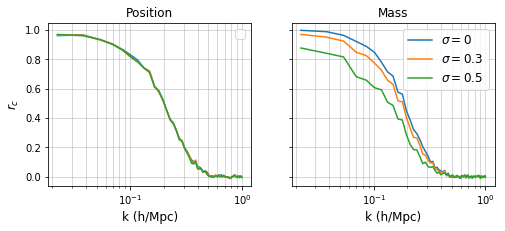

In [20]:
print('Compare position and mass correlations with initial field')

def tmpfunc(folder):
  
    trues = BigFileMesh(folder + 'datap', 's').paint()+1
    truep = BigFileMesh(folder + 'datap', 'mapp').paint()
    truepm = BigFileMesh(folder + 'datam', 'mapp').paint()
    trues /= trues.cmean()
    truep /= truep.cmean()
    truepm /= truepm.cmean()

    ps = FFTPower(trues, mode='1d').power
    k, ps = ps['k'], ps['power']
    pp = FFTPower(truep, mode='1d').power['power']
    ppm = FFTPower(truepm, mode='1d').power['power']
    pspx = FFTPower(trues, second=truep, mode='1d').power['power']
    psmx = FFTPower(trues, second=truepm, mode='1d').power['power']
    meshes = [trues, truep, truepm]
    pks = [k, ps, pp, ppm, pspx, psmx]
    return meshes, pks

fig, ax = plt.subplots(1, 2, figsize = (8, 3), sharex=True, sharey=True)

folder = outpath10 + 'standard/R7/'
meshes, pks = tmpfunc(folder)
k, ps, pp, ppm, pspx, psmx = pks
ax[0].plot(k, pspx/(ps*pp)**0.5, 'C0-')
ax[1].plot(k, psmx/(ps*ppm)**0.5, 'C0-', label='$\sigma=0$')

folder = outpath10 + 'standard/sg30/R7/'
meshes, pks = tmpfunc(folder)
k, ps, pp, ppm, pspx, psmx = pks
ax[0].plot(k, pspx/(ps*pp)**0.5, 'C1-')
ax[1].plot(k, psmx/(ps*ppm)**0.5, 'C1-', label='$\sigma=0.3$')

folder = outpath10 + 'standard/sg50/R7/'
meshes, pks = tmpfunc(folder)
k, ps, pp, ppm, pspx, psmx = pks
ax[0].plot(k, pspx/(ps*pp)**0.5, 'C2')
ax[1].plot(k, psmx/(ps*ppm)**0.5, 'C2', label='$\sigma=0.5$')

fsize = 12
for axis in ax:
    axis.set_xscale('log')
    axis.grid(which='both', lw=0.5)
    axis.set_xlabel('k (h/Mpc)', fontsize=fsize)
    axis.legend( fontsize=fsize)
ax[0].set_ylabel('$r_c$', fontsize=fsize)
ax[0].set_title('Position', fontsize=fsize)
ax[1].set_title('Mass', fontsize=fsize)


Compare standard reconstruction in case of different scatters


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '$r_c$')

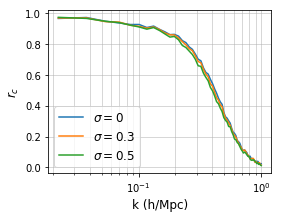

In [21]:
print('Compare standard reconstruction in case of different scatters')

def tmpfunc(folder):
  
    trues = BigFileMesh(folder + 'datap', 's').paint()
    recons = BigFileMesh(folder +  'best-fit/' , 's').paint()
#     trues /= trues.cmean()
#     recons /= recons.cmean()
    
    ps = FFTPower(trues, mode='1d').power
    k, ps = ps['k'], ps['power']
    pr = FFTPower(recons, mode='1d').power['power']
    psrx = FFTPower(recons, second=trues, mode='1d').power['power']
    meshes = [trues, recons]
    pks = [k, ps, pr, psrx]
    return meshes, pks

fig, ax = plt.subplots(1,1, figsize = (4, 3), sharex=True, sharey=True)
ax = [ax]
folder = outpath10 + 'standard/R7/'
meshes, pks = tmpfunc(folder)
k, ps, pr, psrx = pks
plt.plot(k, psrx/(ps*pr)**0.5, 'C0-', label='$\sigma=0$')

folder = outpath10 + 'standard/sg30/R7/'
meshes, pks = tmpfunc(folder)
truep1 = meshes[1]
k, ps, pr, psrx = pks
plt.plot(k, psrx/(ps*pr)**0.5, 'C1-', label='$\sigma=0.3$')


folder = outpath10 + 'standard/sg50/R7/'
meshes, pks = tmpfunc(folder)
truep2 = meshes[1]
k, ps, pr, psrx = pks
plt.plot(k, psrx/(ps*pr)**0.5, 'C2-', label='$\sigma=0.5$')

fsize = 12
for axis in ax:
    axis.set_xscale('log')
    axis.grid(which='both', lw=0.5)
    axis.set_xlabel('k (h/Mpc)', fontsize=fsize)
    axis.legend( fontsize=fsize)
ax[0].set_ylabel('$r_c$', fontsize=fsize)
# ax[0].set_title('Position', fontsize=fsize)


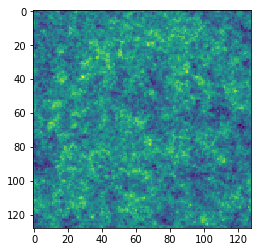

In [15]:
plt.imshow(meshes[0][...].sum(axis=0))

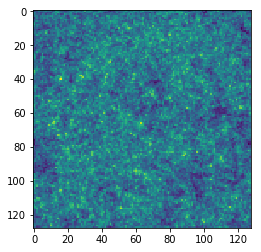

In [16]:
plt.imshow(meshes[1][...].sum(axis=0))

# Noise 

In [104]:
zz = 0 
import yaml
project = '/project/projectdirs/m3035/chmodi/cosmo4d/'
train = project + 'train/'
data = project + 'data/'
with open(project + 'train/models.yaml', 'r') as ymlfile:
    cfg = yaml.load(ymlfile)


ptpath = train + cfg['%s-%s'%(int(bs),nc)][zz][numd]['ppath']
mtpath  = ptpath + cfg['%s-%s'%(int(bs),nc)][zz][numd]['mpath']
print('Loaded and saved in \n%s'%mtpath)

ptup, pftname, plocal, pdict = ntools.setuppos2(ptpath)
mtup, mftname, mlocal, mdict = ntools.setupmass(mtpath )
R1 = pdict['R1']
try : R2 = pdict['R2']
except :
    sfac = pdict['sfac']
    R2 = R1*sfac


#model                                                                                                                                                                                                                                                                                                                       
print('Reading Files')
meshdict, dummy = ntools.readfiles(pm, project + '/data/z%02d/L%04d_N%04d_S%04d_05step/'%(zz*10, bs, nc, seed), \
                                   R1=R1, R2=R2, abund=True, doexp=False, mexp=None, cc=None, stellar=False)

ftt = ntools.createdata(pm, meshdict, pdict['pftname'], plocal)
mftt = ntools.createdata(pm, meshdict, mftname, mlocal)
nnpred = ntools.applynet(ftt, ptup).reshape(nc, nc, nc)
nnmass = ntools.applynet(mftt, mtup).reshape(nc, nc, nc)

predict = pm.create(mode ='real')
predict[...] = nnpred*nnmass
predictR = ft.smooth(predict, Rsm, 'fingauss')


#data                                                                                                                                                                                                                                                                                                                        

print('Generating data')
#hdictf = ntools.gridhalos(pm, scratch +'/data/L%04d_N%04d_S%04d_40step/'%(bs, 4*nc, seed), rank=num, R1=R1, R2=R2, pmesh=True)                                                                                                                                                                                              
#datapt = pm.create(mode='real', zeros=True)                                                                                                                                                                                                                                                                                 
#datapt[...] = hdictf[0]['halomesh']                                                                                                                                                                                                                                                                                         
hdictf = ntools.gridhalos(pm, dpath=project +'/data/z%02d/L%04d_N%04d_S%04d_40step/'%(zz*10, bs,
                            4*nc, seed), R1=R1, R2=R2, pmesh=False, abund=True, doexp=False, mexp=None, cc=None, stellar=False)[1]
datap = pm.paint(hdictf['position'][:num], mass = hdictf['mass'][:num])
datapR = ft.smooth(datap, Rsm, 'fingauss')

print('Data generated')


Loaded and saved in 
/project/projectdirs/m3035/chmodi/cosmo4d/train/L0400_N0128_05step-n10/width_3/Wts_30_10_1/r1rf1/hlim-13_nreg-43_batch-5/eluWts-10_5_1/blim-20_nreg-23_batch-100/
Network architecture for position: 30, relu; 10, relu; 1, sigmoid; 
Width of sigmoid is =  3
Position features are  ['final', 'R1', 'R12']
Network architecture for position: 10, elu; 5, elu; 1, linear; 
Reading Files
Read Halo files
BigFileCatalog read
Match abundance


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: argument mode is deprecated. use type=real instead


Generating data
BigFileCatalog read
Match abundance
Data generated


In [7]:

# bins = np.linspace(-3, 3, 300)
# func = dg.normal
# colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', 'k']

# # mms = [1e8, 1e9, 1e10, 1e11, 1e12]
# mms = [1e11]

# ###########################################                                                                                                                                                                                                                                                                                  
# for M0 in mms:
#     print('For M0 = %0.2e'%M0)

#     mbinsm = np.linspace(np.log10(M0)-1, min(13.5, np.log10(M0) + 4), 10)[::-1]
#     mbinsm = np.array([10, 11, 12])[::-1]
    
#     mbinsm = 10**mbinsm
#     msave = [mbinsm[0]*100] + list(mbinsm)

# #                                                                                                                                                                                                                                                                                                                            
#     print('mbinsm -- ', mbinsm)

#     ####                                                                                                                                                                                                                                                                                                                     
#     fig, ax = plt.subplots(3, 3, figsize = (14, 12))
#     fit0 = dg.plot_noise(datapR.value, predictR.value, M0=M0, binfit=bins, c='k', axin=ax, func=func, 
#                          mbin=mbinsm, retfit=True, lsf='--')[0]
#     print('mbinsm -- ', mbinsm)


#     fits = []
#     sgs = [0.3, 0.5]
#     for i, sg in enumerate(sgs):

#         hmass, hpos = dg.scatter_catalog(hdictf['mass'], hdictf['position'], sg)
#         datasg = pm.paint(hpos[:num], mass = hmass[:num])
#         datasgR = ft.smooth(datasg, Rsm, 'fingauss')
#         fitt = dg.plot_noise(datasgR.value, predictR.value, M0=M0, binfit=bins, c=colors[i], 
#                              axin=ax, func=func, mbin=mbinsm, retfit=True)[0]
#         fits.append(fitt)



For M0 = 1.00e+11
mbinsm --  [12 11 10]


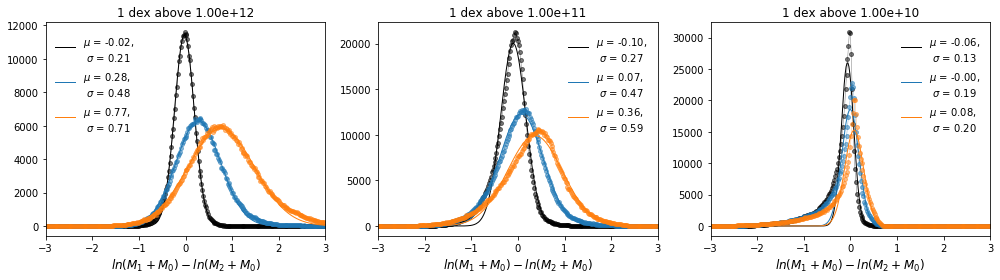

In [106]:
normed = False
bins = np.linspace(-3, 3, 300)
func = dg.normal
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', 'k']
fsize = 12

# mms = [1e8, 1e9, 1e10, 1e11, 1e12]
mms = [1e11]

###########################################                                                                                                                                                                                                                                                                                  
for M0 in mms:
    print('For M0 = %0.2e'%M0)

    mbinsm = np.linspace(np.log10(M0)-1, min(13.5, np.log10(M0) + 4), 10)[::-1]
    mbinsm = np.array([10, 11, 12])[::-1]
    print('mbinsm -- ', mbinsm)

    ###############
    mbinsm = 10**mbinsm
    msave = [mbinsm[0]*100] + list(mbinsm)
    grid1, grid2 = datapR.value, predictR.value
    binfit=bins
    mbin = mbinsm
    xtest = binfit
#                                                                                                                                                                                                                                                                                                                            
    ####                                                                                                                                                                                                                                                                                                                     
    fig, axar = plt.subplots(1, 3, figsize = (14, 4))

    scatter = dg.gridscatter(grid1, grid2, mbin, gridbase=None)
    fit, data = dg.functolog(func, scatter, M0 = M0, binfit = binfit, x0=[1000, 0, 0.5], normed=normed)

    for foo in range(axar.flatten().size):
        ax = axar.flatten()[foo]
        ax.set_title("1 dex above %0.2e"%mbin[foo], fontsize = fsize)
    
        p = ax.plot(*data[foo], ms = 4, color = 'k', marker = "o", alpha = 0.5, lw=0.5)
        l = ax.plot(xtest, func(xtest, *fit[foo].x), ls = '-', color = 'k', lw = 1, alpha=1, 
                 label = "$\mu$ = %0.2f, \n $%s$ = %0.2f"%(fit[foo].x[1], '\sigma', fit[foo].x[2]))

    
    sgs = [0.3, 0.5]
    for i, sg in enumerate(sgs):

        hmass, hpos = dg.scatter_catalog(hdictf['mass'], hdictf['position'], sg)
        datasg = pm.paint(hpos[:num], mass = hmass[:num])
        datasgR = ft.smooth(datasg, Rsm, 'fingauss')
        grid1, grid2 = datasgR.value, predictR.value
        scatter = dg.gridscatter(grid1, grid2, mbin, gridbase=None)
        fit, data = dg.functolog(func, scatter, M0 = M0, binfit = binfit, x0=[1000, 0, 0.5], normed=normed)

        for foo in range(axar.flatten().size):
            ax = axar.flatten()[foo]
    
            p = ax.plot(*data[foo], ms = 4, color = 'C%d'%i, marker = "o", alpha = 0.5, lw=0.5)
            l = ax.plot(xtest, func(xtest, *fit[foo].x), ls = '-', color = 'C%d'%i, lw = 1, alpha=1, 
                 label = "$\mu$ = %0.2f, \n $%s$ = %0.2f"%(fit[foo].x[1], '\sigma', fit[foo].x[2]))

    for ax in axar:
        ax.legend(loc = 0, fontsize = fsize-2, frameon = False)
        ax.set_xlim(xtest[0], xtest[-1])
            
        ax.set_xlabel(r"$ln(M_1+M_0) - ln(M_2+M_0)$", fontsize = fsize)

    plt.tight_layout()
            


        


### Position

In [107]:
ovd = True

ftt = ntools.createdata(pm, meshdict, pdict['pftname'], plocal)
mftt = ntools.createdata(pm, meshdict, mftname, mlocal)
nnpred = ntools.applynet(ftt, ptup).reshape(nc, nc, nc)
predict = pm.create(mode ='real', value=nnpred)
predictR = ft.smooth(predict, Rsm, 'fingauss')
if ovd : predictR[...] = (predictR[...] - predictR.cmean())/(predictR.cmean())

#data                                                                                                                                                                                                                             

print('Generating data')

hdictf = ntools.gridhalos(pm, dpath=project +'/data/z%02d/L%04d_N%04d_S%04d_40step/'%(zz*10, bs, 4*nc, seed), 
                          R1=R1, R2=R2, pmesh=False, abund=True)[1]
datap = pm.paint(hdictf['position'][:num])
datapR = ft.smooth(datap, Rsm, 'fingauss')
if ovd : datapR[...] = (datapR[...] - datapR.cmean())/(datapR.cmean())

datam = pm.paint(hdictf['position'][:num], mass = hdictf['mass'][:num])
datamR = ft.smooth(datam, Rsm, 'fingauss')


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: argument mode is deprecated. use type=real instead
  


Generating data
BigFileCatalog read
Match abundance


BigFileCatalog read
Match abundance
Round at rlim = 0.05
0.06280594126255823


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: argument mode is deprecated. use type=real instead
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: argument mode is deprecated. use type=real instead


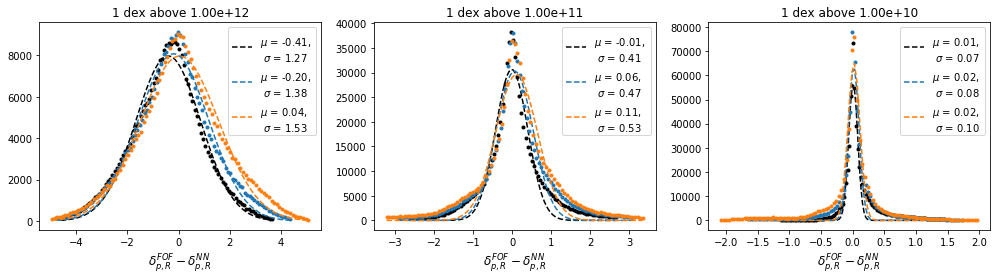

In [109]:
rlim = 0.05
normed = False 
# mbins = np.linspace(np.log10(M0)-1, min(13.5, np.log10(M0) + 4), 10)[::-1]
mbins = np.array((10, 11, 12))[::-1]


#######
hdictf = ntools.gridhalos(pm, dpath=project +'/data/z%02d/L%04d_N%04d_S%04d_40step/'%(zz*10, bs, 4*nc, seed), 
                          R1=R1, R2=R2, pmesh=False, abund=True)[1]
datap = pm.paint(hdictf['position'][:num])
datapR = ft.smooth(datap, Rsm, 'fingauss')
if ovd : datapR[...] = (datapR[...] - datapR.cmean())/(datapR.cmean())

datam = pm.paint(hdictf['position'][:num], mass = hdictf['mass'][:num])
datamR = ft.smooth(datam, Rsm, 'fingauss')

print('Round at rlim = %0.2f'%rlim)
datapround = pm.create(mode='real', value=datap[...])
datapround[...][datapround[...] > rlim] = 1
dataproundR = ft.smooth(datapround, Rsm, 'fingauss')
print(dataproundR[...].mean())
if ovd: dataproundR[...] = (dataproundR[...] - dataproundR[...].mean())/dataproundR[...].mean()
scatter = dg.gridscatter(dataproundR[...], predictR[...], 10**mbins, datamR[...])


fig, ax = plt.subplots(1, 3, figsize = (14, 4))

for i in range(ax.flatten().size):
    axis = ax.flatten()[i]
    
    mean, std = (scatter[i][1] - scatter[i][0]).mean(), (scatter[i][1] - scatter[i][0]).std()
    bins = np.linspace(mean - 3*std, mean + 3*std, num=100)
#     bins = np.linspace(-4, 4, num=100)
    if normed: x0 = [1/(bins[-1]-bins[0]), mean, std]
    else: x0 = [scatter[i][0].size, mean, std]
    xx, yy, res = dg.fitpdf(scatter[i][1] - scatter[i][0], func, bins=bins, normed=normed, x0=x0)

    axis.plot(xx, yy, 'k.')
    axis.plot(xx, func(xx, *res.x), 'k--', 
              label = "$\mu$ = %0.2f, \n $%s$ = %0.2f"%(res.x[1], '\sigma', res.x[2]))
    
sgs = [0.3, 0.5]
for foo, sg in enumerate(sgs):

    hmass, hpos = dg.scatter_catalog(hdictf['mass'], hdictf['position'], sg)
    
    datamsg = pm.paint(hpos[:num], mass = hmass[:num])
    datamRsg = ft.smooth(datam, Rsm, 'fingauss')

    datapsg = pm.paint(hpos[:num])
    datapround = pm.create(mode='real', value=datapsg[...])
    datapround[...][datapround[...] > rlim] = 1
    dataproundRsg = ft.smooth(datapround, Rsm, 'fingauss')
    if ovd: dataproundRsg[...] = (dataproundRsg[...] - dataproundRsg[...].mean())/dataproundRsg[...].mean()
    scatter = dg.gridscatter(dataproundRsg[...], predictR[...], 10**mbins, datamRsg[...])
# #     scatter

    for i in range(ax.size):
        axis = ax.flatten()[i]
        mean, std = (scatter[i][1] - scatter[i][0]).mean(), (scatter[i][1] - scatter[i][0]).std()
        bins = np.linspace(mean - 3*std, mean + 3*std, num=100)
        if normed: x0 = [1/(bins[-1]-bins[0]), mean, std]
        else: x0 = [scatter[i][0].size, mean, std]
        xx, yy, res = dg.fitpdf(scatter[i][1] - scatter[i][0], func, bins=bins, normed=normed, x0=x0)
        axis.plot(xx, yy, 'C%d.'%foo)
        axis.plot(xx, func(xx, *res.x), 'C%d--'%foo, 
          label = "$\mu$ = %0.2f, \n $%s$ = %0.2f"%(res.x[1], '\sigma', res.x[2]))

for i in range(ax.size):
    axis = ax.flatten()[i]
    axis.set_title("1 dex above %0.2e"%(10**mbins[i]), fontsize = fsize)
    axis.set_xlabel(r"$\delta_{p,R}^{FOF} - \delta_{p,R}^{NN}$", fontsize = fsize)
    axis.legend()

plt.tight_layout()


In [115]:
hdictf['mass'][:64000][-1]/1e12

4.950631492653968